In [22]:
!pip install -U ydata-profiling

In [23]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product

## If you have an error here saying ydata_profiling is not available
## Run the instructions above
## IF you are still unable to install `ydata-profiling` through this method, 
## Comment out the line below importing ProfileReport
from ydata_profiling import ProfileReport

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

In [18]:
data=pd.read_csv("DM2425_ABCDEats_DATASET.csv")
data.tail()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23
31883,f4e366c281,8670,30.0,1,1,1,NaN,0,FREEBIE,DIGI,...,0,0,0,0,0,0,0,0,0,0
31884,f6b6709018,8670,NaN,1,1,0,NaN,0,DELIVERY,DIGI,...,0,0,1,0,0,0,0,0,0,0
31885,f74ad8ce3f,8670,24.0,1,1,1,NaN,0,-,DIGI,...,0,0,0,0,0,0,0,0,0,0
31886,f7b19c0241,8670,34.0,1,1,0,NaN,0,DISCOUNT,DIGI,...,0,0,0,0,0,0,0,0,0,0
31887,fd40d3b0e0,4660,30.0,1,1,0,NaN,0,-,CASH,...,0,0,1,0,0,0,0,0,0,0


In [41]:
data["Hours_added"]=data[['HR_0','HR_1','HR_2','HR_3','HR_4','HR_5','HR_6','HR_7','HR_8','HR_9','HR_10','HR_11','HR_12','HR_13','HR_14','HR_15','HR_16','HR_17','HR_18','HR_19','HR_20','HR_21','HR_22','HR_23']].sum(axis=1)
data

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,Hours_added
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,0,0,0,2,0,0,0,0,0,2.0
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0,0,0,0,0,0,0,0,2.0
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,...,0,0,0,0,0,0,0,0,0,2.0
3,180c632ed8,4660,NaN,2,3,1,0.0,2,DELIVERY,DIGI,...,0,0,0,0,0,0,0,0,0,2.0
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,-,DIGI,...,0,0,0,0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,f4e366c281,8670,30.0,1,1,1,NaN,0,FREEBIE,DIGI,...,0,0,0,0,0,0,0,0,0,1.0
31884,f6b6709018,8670,NaN,1,1,0,NaN,0,DELIVERY,DIGI,...,0,1,0,0,0,0,0,0,0,1.0
31885,f74ad8ce3f,8670,24.0,1,1,1,NaN,0,-,DIGI,...,0,0,0,0,0,0,0,0,0,1.0
31886,f7b19c0241,8670,34.0,1,1,0,NaN,0,DISCOUNT,DIGI,...,0,0,0,0,0,0,0,0,0,1.0


__DUPLICATES AND MISSING VALUES__

In [44]:
data_duplicates=data.duplicated().sum()
print(data_duplicates)

data_missing_values=data.isnull().sum()
data_missing_values

13


customer_id                    0
customer_region                0
customer_age                 727
vendor_count                   0
product_count                  0
is_chain                       0
first_order                  106
last_order                     0
last_promo                     0
payment_method                 0
CUI_American                   0
CUI_Asian                      0
CUI_Beverages                  0
CUI_Cafe                       0
CUI_Chicken Dishes             0
CUI_Chinese                    0
CUI_Desserts                   0
CUI_Healthy                    0
CUI_Indian                     0
CUI_Italian                    0
CUI_Japanese                   0
CUI_Noodle Dishes              0
CUI_OTHER                      0
CUI_Street Food / Snacks       0
CUI_Thai                       0
DOW_0                          0
DOW_1                          0
DOW_2                          0
DOW_3                          0
DOW_4                          0
DOW_5     

__OUTLIERS__

In [20]:
## OUTLIERS ##
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Detect outliers using the IQR method
outliers_dict = {}

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outliers_dict[col] = len(outliers)

outliers_dict

{'customer_age': 1083,
 'vendor_count': 1524,
 'product_count': 2371,
 'is_chain': 3155,
 'first_order': 0,
 'last_order': 0,
 'CUI_American': 3511,
 'CUI_Asian': 3475,
 'CUI_Beverages': 5435,
 'CUI_Cafe': 1366,
 'CUI_Chicken Dishes': 3248,
 'CUI_Chinese': 3522,
 'CUI_Desserts': 2016,
 'CUI_Healthy': 2169,
 'CUI_Indian': 3448,
 'CUI_Italian': 6448,
 'CUI_Japanese': 6301,
 'CUI_Noodle Dishes': 2226,
 'CUI_OTHER': 7041,
 'CUI_Street Food / Snacks': 4249,
 'CUI_Thai': 2378,
 'DOW_0': 1406,
 'DOW_1': 1495,
 'DOW_2': 1589,
 'DOW_3': 1654,
 'DOW_4': 1784,
 'DOW_5': 1708,
 'DOW_6': 1978,
 'HR_0': 0,
 'HR_1': 1284,
 'HR_2': 1492,
 'HR_3': 2524,
 'HR_4': 2369,
 'HR_5': 2028,
 'HR_6': 1752,
 'HR_7': 1896,
 'HR_8': 2954,
 'HR_9': 4925,
 'HR_10': 6599,
 'HR_11': 7532,
 'HR_12': 6498,
 'HR_13': 5457,
 'HR_14': 5105,
 'HR_15': 6039,
 'HR_16': 7143,
 'HR_17': 7616,
 'HR_18': 6691,
 'HR_19': 4892,
 'HR_20': 3068,
 'HR_21': 1760,
 'HR_22': 1181,
 'HR_23': 1124}

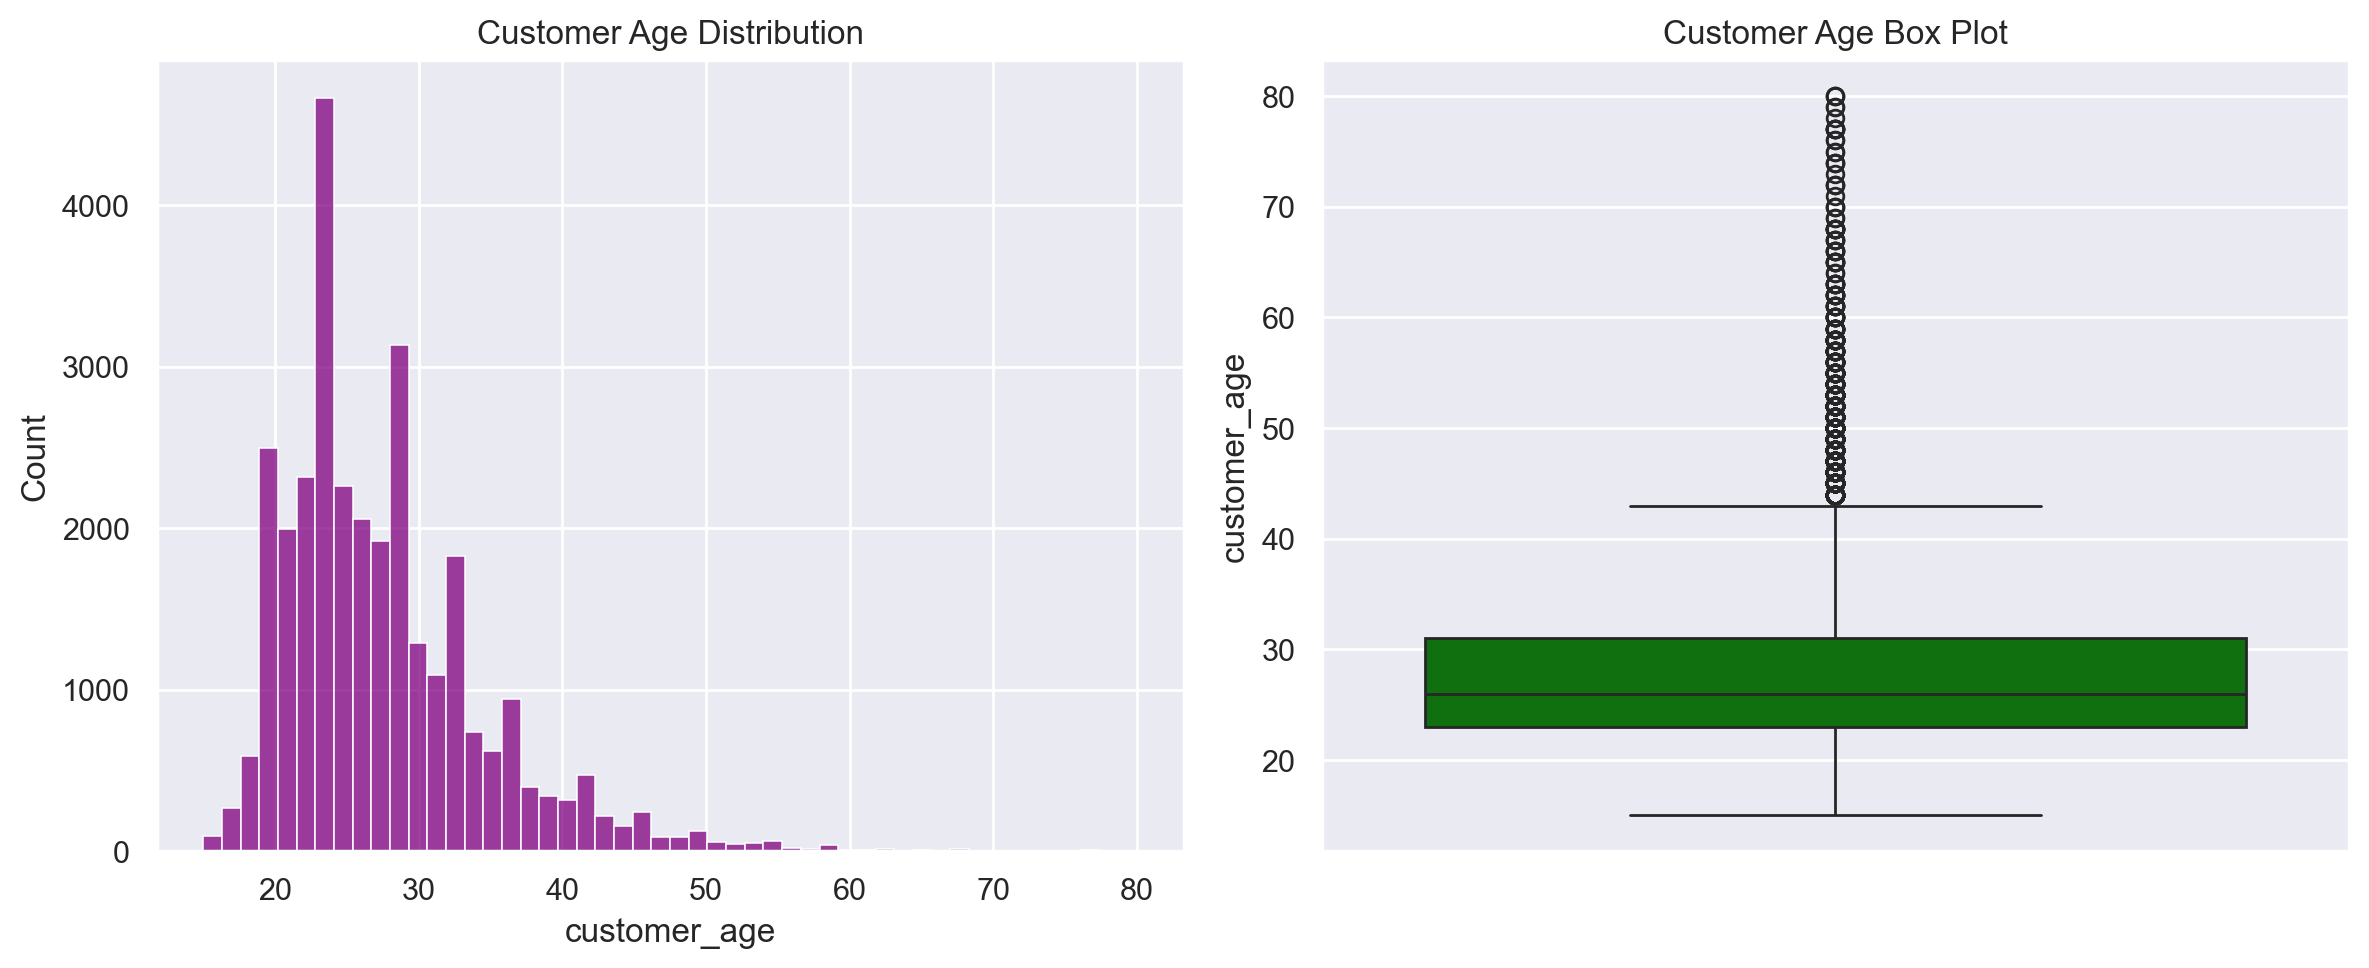

In [27]:
# Let's simplify the visualization process by splitting the plots

# Histogram and Boxplot for the first feature: 'customer_age'
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data['customer_age'].dropna(), bins=50, color='purple')
plt.title('Customer Age Distribution')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data['customer_age'].dropna(), color='green')
plt.title('Customer Age Box Plot')

plt.tight_layout()
plt.show()

__METRIC AND NON METRIC FEATURES__

In [35]:
non_metric_features = ["customer_id", "customer_region", "last_promo", "payment_method"]
metric_features = data.columns.drop(non_metric_features).to_list()

__ALL HISTOGRAMS__

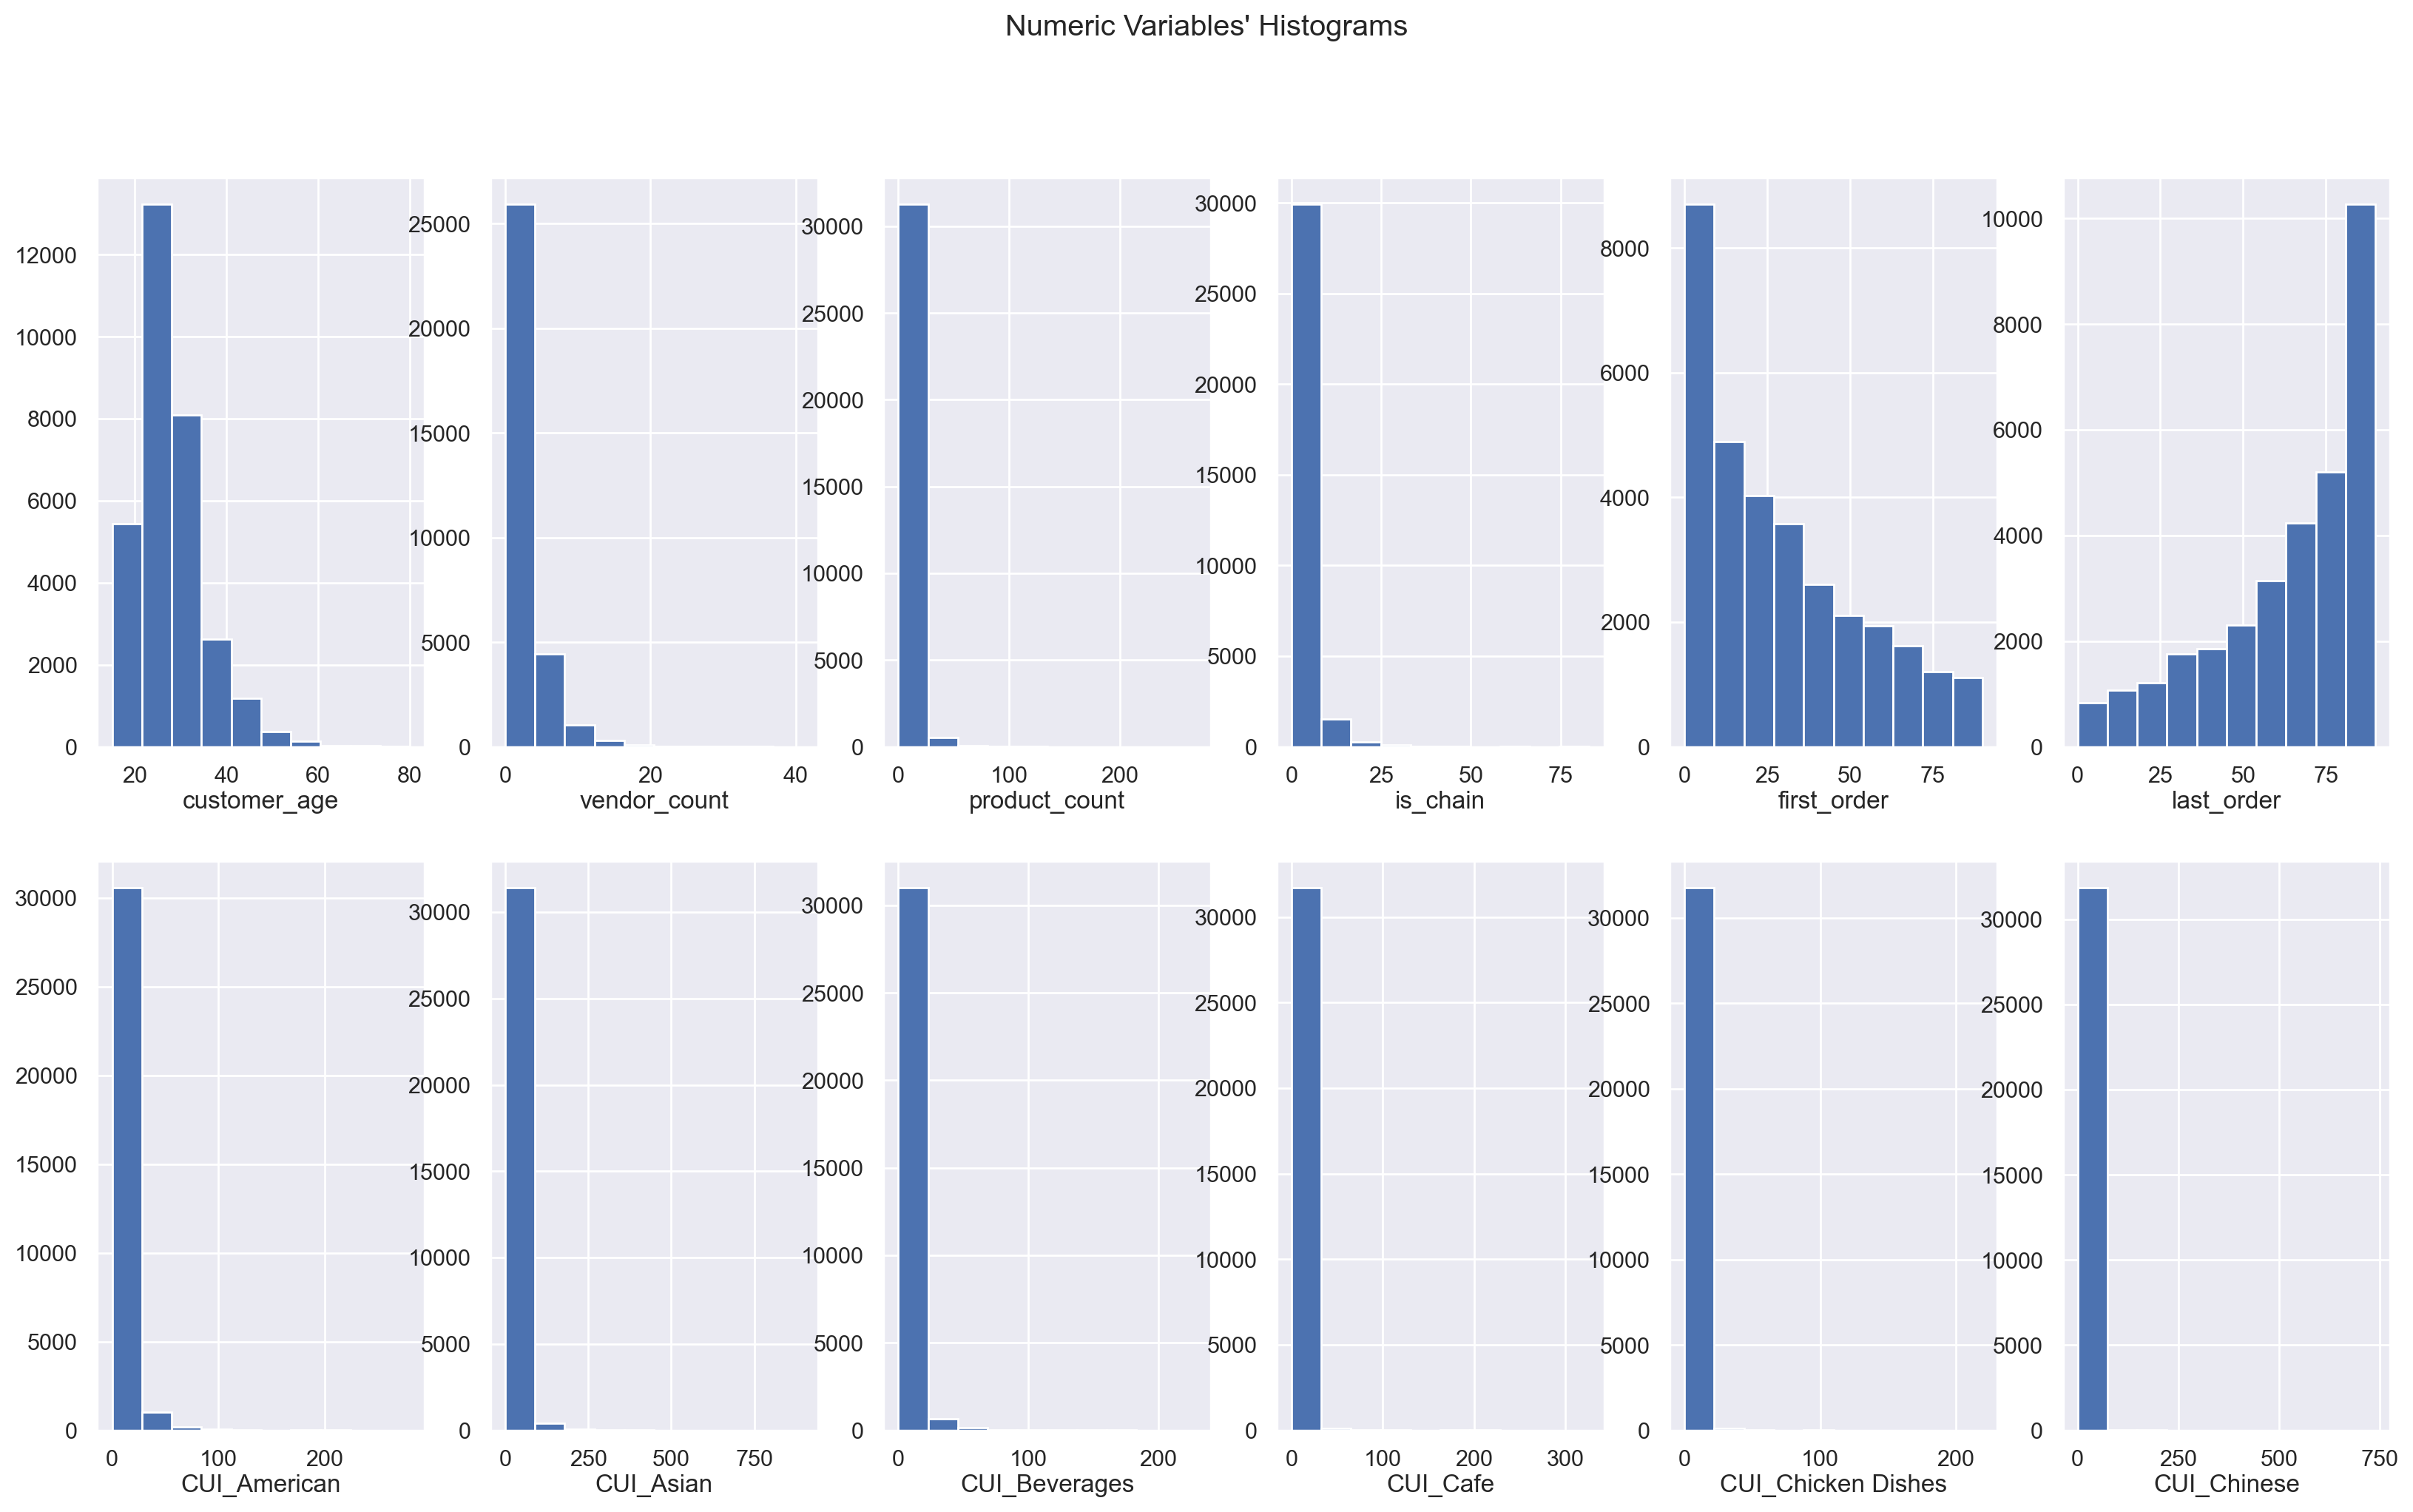

In [37]:
# Plot ALL Numeric Variables' Histograms in one figure

sns.set() ## Reset to darkgrid

sp_rows = 2
sp_cols = 6


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(data[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    # if the exp_analysis directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'eda'))
    
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_histograms.png'), dpi=200)

plt.show()

__ALL BOXPLOTS__

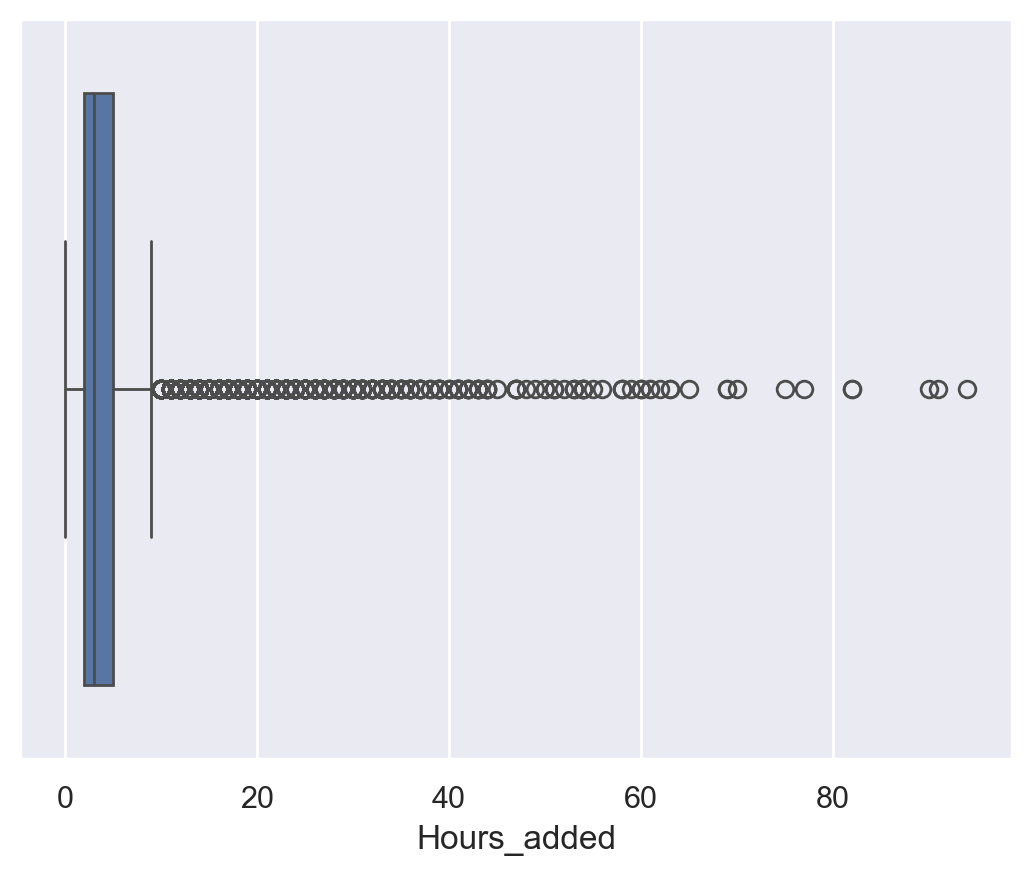

In [43]:
sns.boxplot(x=data["Hours_added"]) #epa ya

plt.show()